In [1]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import subprocess
import astropy.units as u
from synphot import SpectralElement, Empirical1D, SourceSpectrum, Observation

from model_W0116_spec import model_W0116_spec
from polModel import PolModel

import os
gd_folder = os.getcwd()+"/../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

sys.path.append("../plots/utility_functions/")
from objectProperties import ObjectProperties
from readExtrapolatedSpectra import ReadExtrapolatedSpectra

sys.path.append("../Filter_Curves/")
from readBands import ReadBands

In [2]:
#Load the properties of the BHDs
wid = "W0116-0505"
op = ObjectProperties([wid])

In [3]:
#Change the values of v-band pol in W0116 to what we would have if there is no polarization in Lyalpha. This is calculated in the notebook in plots/SKIRTOR_fit_correctedVband/fit_pfrac.ipynb.
op.pfrac['W0116-0505']['v_HIGH'] = 13.581644392324971
op.epfrac['W0116-0505']['v_HIGH'] = 0.5364890716303004
#13.581644392324971 0.5364890716303004

In [4]:
#Load the bands.
bands = ReadBands()
for bname in bands.bandnames:
    print(bname, bands.bp[bname].barlam(), bands.bp[bname].fwhm(), bands.bp[bname].rectwidth())

R_SPECIAL 6501.229535920617 Angstrom 1159.881393925198 Angstrom 1624.9974574790472 Angstrom
I_BESS 7925.773360798338 Angstrom 1080.5202412457434 Angstrom 1433.1539789444323 Angstrom
v_HIGH 5531.691038305597 Angstrom 850.6231300284223 Angstrom 1195.0838113345558 Angstrom


In [5]:
#Load the spectra for each BHD, extended using the best-fit SED, although here we will not care about the extension.
specs = ReadExtrapolatedSpectra()

Wavelength range for object W0019-1046 limited because of sky template
Spec-range: 3001.5 Angstrom - 5423.93 Angstrom
Sky-range: 3199.4 Angstrom - 6724.06 Angstrom
Wavelength range for object W0204-0506 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.70 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.
Wavelength range for object W0831+0140 limited because of sky template
Spec-range: 3786.2 Angstrom - 6672.45 Angstrom
Sky-range: 3789.3 Angstrom - 6682.76 Angstrom
Warning, 2 of 3161 bins contained negative fluxes; they have been set to zero.


## Spectrum, spectrum model and general pol model object

In [6]:
#Load the spectrum. 
spec, spec_model = model_W0116_spec(specs)

In [7]:
full_spec = SourceSpectrum(Empirical1D, points=spec.lam_obs, lookup_table=spec.flam, keep_neg=True)

In [8]:
pol_model = PolModel(spec, spec_model, bands, op)

In [9]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 
mod_chi_all = dict()

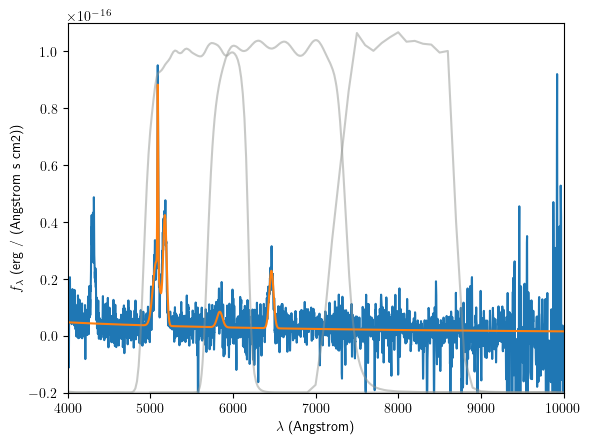

In [10]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

(-5e-17, 5e-17)

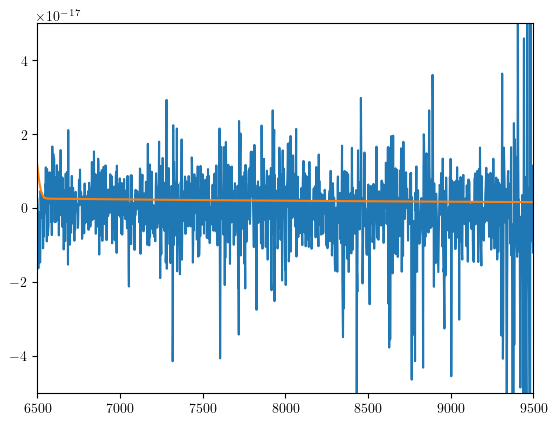

In [11]:
plt.plot(spec.lam_obs, spec.flam-spec_model.flam_model(spec.lam_rest))
plt.plot(spec.lam_obs, spec_model.flam_model(spec.lam_rest))
plt.xlim([6500, 9500])
plt.ylim([-5e-17, 5e-17])

In [12]:
#General plotting function
def pol_plot(mod_p, spec, pol_model, fmt="ko", show_legend=True):

    # data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    # p_measured = data[:,0]
    # p_unc = data[:,1]
    p_measured =pol_model.p_measured
    p_unc = pol_model.p_unc

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    #ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    ax.errorbar(wave, p_measured, yerr=p_unc, fmt=fmt, label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    if show_legend:
        ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [13]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi = a_pars[1]
        return self.gas_obj.p(([theta],[psi])).flatten()[0] * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

In [14]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [15]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([0., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[-8.46637154e-24  7.47405382e+01  7.44822696e+01]
135.93409633634224


##### Allow for different polarization angles.

In [16]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[35.27036983 68.30442908 71.56971776]
116.60007241416469


In [17]:
x0 = np.array([40., 60., 70.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[35.27037381 60.29155904 69.11795297]
116.6000724141685


#### Allow for independent torus opening angles for lines and continuum.

I *believe* that a scatterer very near the accretion disk should be able to be modeled by allowing for different opening angles, which in that model would just simply become for the lines the size of the BLR ring shining into a small scatterer, and for the continuum it would become the covering angle by the scatterer.

In [18]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = PolWaveGas()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi_A = a_pars[1]
        return self.gas_obj.p(([theta],[psi_A])).flatten()[0] * np.ones(len(lam))
    
    #Emission line polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.gas_obj.p(([theta],[psi_B])).flatten()[0] * np.ones(len(lam))
    

In [19]:
scat_obj = Gas_Gas()

In [20]:
x0 = np.array([0., 80., 50., 50.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[88.41020222 68.40288238 71.09527966  1.09032006]
9.832027269529543e-11


In [21]:
pol_model.mod_chi.to(u.deg)

<Quantity [8.76655686e+01, 8.69329386e+01, 3.35760107e-04] deg>

Now, force the polarization angle to be the same, as suggested by the edge on view of Zakamska & Alexandroff (2023).

In [22]:
x0 = np.array([0., 80., 30., 70.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([0., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG3"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p
mod_chi_all[mname] = pol_model.mod_chi

`xtol` termination condition is satisfied.
[-4.53742862e-25  5.65243151e+01  6.79334695e+01  7.59309131e+01]
123.97331522267862


In [23]:
scat_obj.pfrac_A(pol_model.xopt.x, [1]), scat_obj.pfrac_B(pol_model.xopt.x, [1])

(array([0.1356064]), array([0.07910472]))

Now allow for the polarization angle to change, but force the inclination angle to be 90 degrees. 

In [24]:
x0 = np.array([0., 90., 30., 70.])
min_vals = np.array([0., 90., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG4"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[88.41004027 90.         73.47025072 29.88089443]
2.415365102433641e-10


In [25]:
scat_obj.pfrac_A(pol_model.xopt.x, [1]), scat_obj.pfrac_B(pol_model.xopt.x, [1])

(array([0.14363924]), array([0.76107161]))

In [26]:
pol_model.mod_p

<Quantity [0.13581638, 0.11110001, 0.14360003]>

In [27]:
pol_model.mod_chi.to(u.deg)

<Quantity [8.76653307e+01, 8.69326261e+01, 3.35794164e-04] deg>

## Pure dust polarization

In [28]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [29]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi)).flatten()
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

##### Force the same polarization angle. 

In [30]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([0., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[-1.77888662e-21  6.62580313e+01  4.89058462e+01]
608.7065799998477
FW
`xtol` termination condition is satisfied.
[-2.27467552e-24  4.34396490e+01  1.15328668e+01]
531.150517513482
BW
`xtol` termination condition is satisfied.
[-1.32198597e-24  6.85000000e+01  6.34708291e+01]
614.1853850303359

LMC
FWBW
`xtol` termination condition is satisfied.
[-1.37507938e-22  6.63864008e+01  4.95402173e+01]
849.7485958923909
FW
`xtol` termination condition is satisfied.
[-1.13564461e-24  4.24938403e+01  1.63967145e+01]
707.6006396633474
BW
`xtol` termination condition is satisfied.
[-2.22870841e-25  7.35000000e+01  6.44466779e+01]
848.7905643178649

MW
FWBW
`gtol` termination condition is satisfied.
[-2.38525781e-22  3.81169223e+01  3.67686428e-06]
439.1704123427773
FW
`xtol` termination condition is satisfied.
[-2.18599696e-26  4.01788215e+01  9.98364136e+00]
329.0988525974619
BW
`gtol` termination condition is satisfied.
[3.25000678e-33 9.000000

##### Allow for different polarization angles. 

In [31]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[83.16884325 89.99999912 21.28890442]
179.00267866396757
FW
`xtol` termination condition is satisfied.
[80.53753709 76.47145564 11.2359337 ]
162.2504819127836
BW
`xtol` termination condition is satisfied.
[83.14577155 89.99999997 21.26641879]
178.4509769597535

LMC
FWBW
`xtol` termination condition is satisfied.
[84.03031637 89.98435403 16.        ]
508.9484039381888
FW
`xtol` termination condition is satisfied.
[6.92912051e+01 5.97664371e+01 2.25288316e-07]
413.6229755664085
BW
`gtol` termination condition is satisfied.
[83.40809445 89.99999999 17.04011815]
507.12001512544293

MW
FWBW
`xtol` termination condition is satisfied.
[5.35011989e+01 4.85000000e+01 6.41094224e-03]
300.18852256077764
FW
`xtol` termination condition is satisfied.
[6.44304220e+01 5.59999999e+01 3.09813826e-02]
107.56089415228335
BW
`xtol` termination condition is satisfied.
[78.29209539 89.99536739 18.49999992]
204.09222886635786



Now, force the polarization angle to be the same between lines and gas, but allow for the polarization fraction (opening angle) to be different. 

In [32]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()

In [33]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([0., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[-3.26730474e-23  7.37233788e+01  4.27118955e+01  8.98742952e+01]
433.44461637443976
FW
`xtol` termination condition is satisfied.
[3.89167574e-23 5.18705741e+01 1.83916551e-01 7.91019632e+01]
316.3821480929688
BW
`xtol` termination condition is satisfied.
[1.88456094e-23 8.99935655e+01 4.84339759e+01 8.97888349e+01]
436.7904027642529

LMC
FWBW
`xtol` termination condition is satisfied.
[7.53893010e-23 7.33970435e+01 4.32303487e+01 8.98795180e+01]
737.924867395367
FW
`xtol` termination condition is satisfied.
[-5.08141140e-25  4.87100520e+01  7.20451815e-03  7.63473798e+01]
483.7745468514464
BW
`xtol` termination condition is satisfied.
[-2.03811394e-25  8.99983652e+01  4.93408228e+01  8.97246836e+01]
744.1242918655819

MW
FWBW
`xtol` termination condition is satisfied.
[-9.13536089e-26  4.83192659e+01  8.83528256e-03  8.99314926e+01]
311.79625860036606
FW
`xtol` termination condition is satisfied.
[-9.48840189e-24  4.86631794e+01  3.

## Gas and Dust polarization 

##### Require the same inclination

In [34]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta, psi_B)).flatten()
    

In [35]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.82709418 73.64789093 42.65894355 89.87465653]
433.4451978835832
FW
`xtol` termination condition is satisfied.
[ 5.39990499 51.86149645  0.10195772 79.09989064]
316.3716642613422
BW
`xtol` termination condition is satisfied.
[ 1.27986361 89.99490702 48.42213726 89.78838949]
436.78373515132097

LMC
FWBW
`xtol` termination condition is satisfied.
[ 2.98597262 73.46742631 43.28272115 89.87923022]
737.9229697116727
FW
`xtol` termination condition is satisfied.
[4.69469306e+00 4.87027824e+01 2.32014913e-02 7.63455021e+01]
483.7812513502598
BW
`xtol` termination condition is satisfied.
[ 4.37382854 89.99995777 49.34041964 89.72403179]
744.1110215227135

MW
FWBW
`xtol` termination condition is satisfied.
[6.08785528e+00 4.83188338e+01 1.54204720e-02 8.99314925e+01]
311.798281662752
FW
`xtol` termination condition is satisfied.
[7.81757619e+00 4.86568036e+01 1.57037591e-02 7.34814838e+01]
155.19277045891022
BW
`xtol` termination condition 

##### Allow for different inclinations

In [36]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 2

        #Load the simple gas model. 
        self.dust_obj = PolWaveDust(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = PolWaveGas(fw=self.fw, bw=self.bw)

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta_A = a_pars[0] * np.ones(len(lam))
        psi_A   = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_A, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:]
        theta_B = b_pars[0] * np.ones(len(lam))
        psi_B   = b_pars[1] * np.ones(len(lam))
        return self.dust_obj.p((lam.to(u.AA).value, theta_B, psi_B)).flatten()
    

In [37]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 80., 45.])
    min_vals = np.array([0., 0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p
            mod_chi_all[mname] = pol_model.mod_chi

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 2.8555     73.86871999 42.8058474  58.42126115 89.91565515]
433.4477675040031
FW
`xtol` termination condition is satisfied.
[8.95810985e+01 5.24129108e+01 1.29537235e-02 6.60000000e+01
 8.99993753e+01]
309.6793073485841
BW
`xtol` termination condition is satisfied.
[ 4.30953587 89.98005898 48.43130501 89.52652698 89.94212233]
436.86530620628

LMC
FWBW
`xtol` termination condition is satisfied.
[ 4.33804027 73.49836238 43.30416556 54.41454341 89.92969557]
737.9228938078537
FW
`xtol` termination condition is satisfied.
[2.39024110e+01 4.87100472e+01 5.68741962e-02 4.90256244e+01
 7.64274823e+01]
483.8503290015233
BW
`xtol` termination condition is satisfied.
[ 5.10532488 89.98817286 49.34686873 89.5534766  89.90429609]
744.2313253362086

MW
FWBW
`xtol` termination condition is satisfied.
[7.28323209e+00 4.83192263e+01 3.38099308e-04 1.54510138e+01
 8.99650221e+01]
311.79567240853896
FW
`xtol` termination condition is satisfied.
[9.898

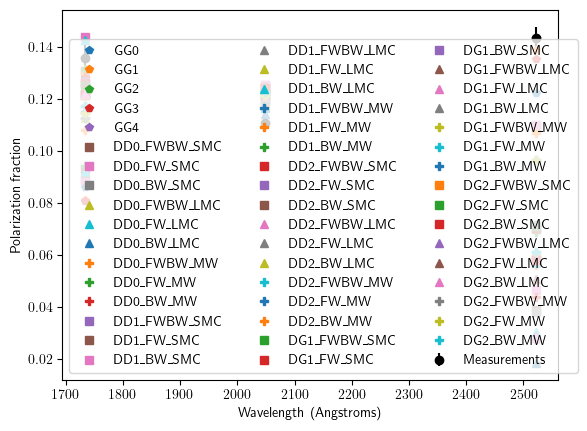

In [38]:
pol_plot(mod_p_all, spec, pol_model)

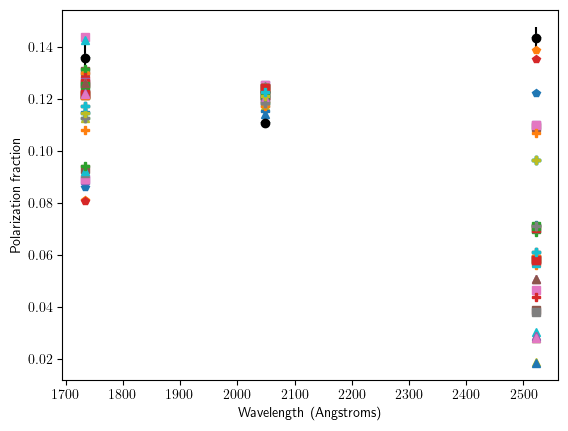

In [39]:
pol_plot(mod_p_all, spec, pol_model, show_legend=False)

In [40]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

GG2 9.832027269529543e-11 [88.41020222 68.40288238 71.09527966  1.09032006]
GG4 2.415365102433641e-10 [88.41004027 90.         73.47025072 29.88089443]
DD1_FW_MW 107.56089415228335 [6.44304220e+01 5.59999999e+01 3.09813826e-02]
GG1 116.6000724141685 [35.27037381 60.29155904 69.11795297]
GG3 123.97331522267862 [-4.53742862e-25  5.65243151e+01  6.79334695e+01  7.59309131e+01]
GG0 135.93409633634224 [-8.46637154e-24  7.47405382e+01  7.44822696e+01]
DG1_FW_MW 155.19277045891022 [7.81757619e+00 4.86568036e+01 1.57037591e-02 7.34814838e+01]
DD2_FW_MW 155.2396934010149 [-9.48840189e-24  4.86631794e+01  3.67488959e-01  7.34833905e+01]
DG2_FW_MW 155.41929405516856 [9.89897834e+00 4.86612984e+01 8.90981490e-05 8.49677589e-01
 8.23120999e+01]
DD1_FW_SMC 162.2504819127836 [80.53753709 76.47145564 11.2359337 ]
DD1_BW_SMC 178.4509769597535 [83.14577155 89.99999997 21.26641879]
DD1_FWBW_SMC 179.00267866396757 [83.16884325 89.99999912 21.28890442]
DD1_BW_MW 204.09222886635786 [78.29209539 89.99536739 

In [41]:
pw = PolWaveGas()
for mname in ['GG2','GG4']:
    dchi, th, psi1, psi2 = xopt_all[mname].x
    print(mname, dchi, th, psi1, psi2)
    print(mname, pw.p((th, psi1)), pw.p((th, psi2)))

GG2 88.41020222287352 68.40288238495492 71.0952796634992 1.0903200558466095
GG2 0.14363921995457554 0.7610717743062899
GG4 88.41004027391065 90.0 73.4702507151309 29.88089442880664
GG4 0.14363923736087839 0.7610716146345123


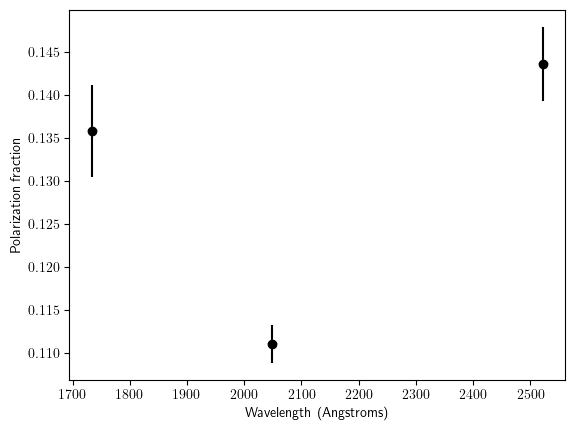

In [42]:
mod_p_show = dict()
for mname in xopt_all.keys():
    if xopt_all[mname].fun < 1.:
        mod_p_show[mname] = mod_p_all[mname]
pol_plot(mod_p_show, spec, pol_model, show_legend=False)

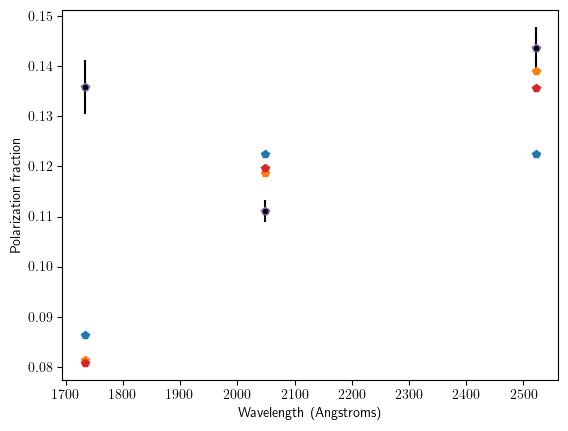

In [43]:
mod_p_gas = dict()
for mname in xopt_all.keys():
    if mname[:2]=="GG":
        mod_p_gas[mname] = mod_p_all[mname]
pol_plot(mod_p_gas, spec, pol_model, show_legend=False, fmt='k.')

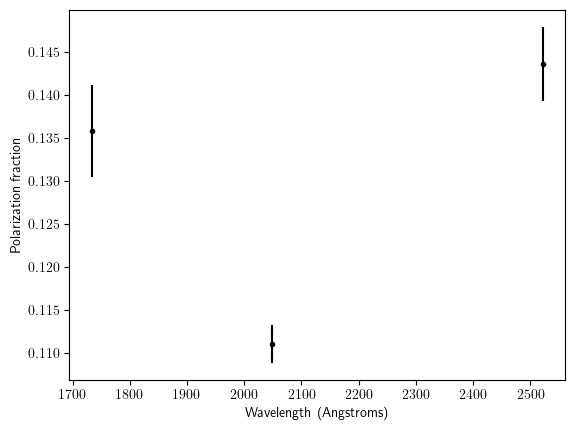

In [44]:
mod_p_dust = dict()
for mname in xopt_all.keys():
    if mname[:2]!="GG" and xopt_all[mname].fun < 70.:
        mod_p_dust[mname] = mod_p_all[mname]
pol_plot(mod_p_dust, spec, pol_model, show_legend=False, fmt='k.')